## The Dawid-Skene model with priors: ADDRESS

In [1]:
from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/Users/visenger/Library/Jupyter


In [6]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix

In [7]:
#read data from csv
#header: num, annotator-id, y, label

#FLIGHTS
init_data = pd.read_csv("data/address-dawid-skene.csv")

init_data = init_data.replace({'annotator-id': {5: 3, 7:4}})

In [8]:
init_data.head()

,num,annotator-id,y,label
0,59,0,0,0
1,59,2,1,0
2,137,0,0,1
3,137,2,1,1
4,137,3,1,1


In [9]:
I = 500              # number of items
tmp_data = init_data.loc[init_data["num"]<I]

data = tmp_data.head(I)
z_true = np.asarray(data["label"].values)

J_num= np.unique(np.asarray(data["annotator-id"].values))
print(J_num)
J = J_num.size      # number of annotators
K = 2               # number of classes: clean (0) or error (1) 
N = I * J

[0 1 2 3 4]


In [11]:
#data.loc[data["annotator-id"]==7].count()

In [12]:
# create data triplets
jj = list(np.asarray(data["annotator-id"].values))  # annotator IDs
ii = list(np.asarray(data["num"].values))           # item IDs
y = list(np.asarray(data["y"].values))              # response


In [13]:
f_majority_vote = lambda x: np.bincount(np.array( x )).argmax()
data["majority-vote"] = data.groupby("num")["y"].transform(f_majority_vote)

f_at_least_one_vote = lambda x: np.bincount(np.array(x)).argmin()
data["min-1"] = data.groupby("num")["y"].transform(f_at_least_one_vote)

data.head()

/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,num,annotator-id,y,label,majority-vote,min-1
0,59,0,0,0,0,0
1,59,2,1,0,0,0
2,137,0,0,1,1,0
3,137,2,1,1,1,0
4,137,3,1,1,1,0


Confusion matrix in binary classification, the count of true negatives is
$C_{0,0}$, false negatives is $C_{1,0}$, true positives is
$C_{1,1}$ and false positives is $C_{0,1}$.

In [14]:
z_majority_vote = np.asarray(data["majority-vote"].values)

confMat_majority_vote = confusion_matrix( z_true, z_majority_vote )
print( "Majority vote estimate of true category:\n" , confMat_majority_vote )

Majority vote estimate of true category:
 [[252  43]
 [181  24]]


In [68]:
z_min_1 =np.asarray(data["min-1"].values)

confMat_min_1 = confusion_matrix( z_true, z_min_1 )
print( "Min-1 estimate of true category:\n" , confMat_min_1 )

Min-1 estimate of true category:
 [[124 171]
 [137  68]]


In [28]:
# class prevalence (flat prior)
alpha = np.ones( K )

# individual annotator confusion matrices - dominant diagonal
beta = np.ones( (K,K) ) + np.diag( np.ones(K) )

In [29]:
z_init = np.asarray(data["majority-vote"].values)
#z_init = np.asarray(data["min-1"].values)

model = pm.Model()

with model:
    pi = pm.Dirichlet( 'pi', a=alpha, shape=K )
    theta = pm.Dirichlet( 'theta', a=beta, shape=(J,K,K) )
    z = pm.Categorical( 'z', p=pi, shape=I, testval=z_init )
    y_obs = pm.Categorical( 'y_obs', p=theta[ jj, z[ ii ] ], observed=y )

/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [30]:
with model:
    step1 = pm.Metropolis( vars=[pi,theta] )
    step2 = pm.CategoricalGibbsMetropolis( vars=[z] )
    trace = pm.sample( 5000, step=[step1, step2], progressbar=True )


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [theta]
>>Metropolis: [pi]
>CategoricalGibbsMetropolis: [z]
Sampling 4 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/pyth

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128546588>,
      dtype=object)

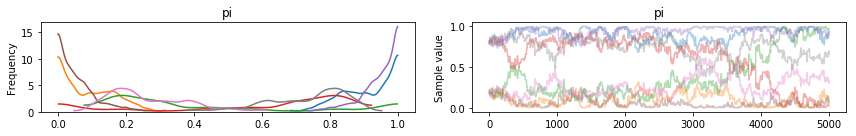

In [31]:
pm.traceplot( trace, varnames=['pi'] )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119314940>,
      dtype=object)

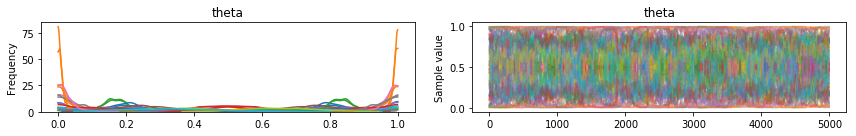

In [32]:
pm.traceplot( trace, varnames=['theta'] )

In [33]:
#to long
#pm.traceplot( trace, varnames=['z'] )

In [34]:
#error:
#pm.traceplot( trace, varnames=['y_obs'] )

In [35]:
#for n in range(100, 10000, 100):
n=1000
z = trace['z'][-n:,:]
z_hat = np.zeros( I )

for i in range( I ):
    z_hat[ i ] = np.bincount( z[:,i] ).argmin()
    
#unique, counts = np.unique(z_hat, return_counts=True)    
#print("number of samples:", n)
#print(np.asarray((unique, counts)).T)

In [64]:
def f1(confMat):
    tn=confMat[0][0]
    fp=confMat[0][1]
    fn=confMat[1][0]
    tp=confMat[1][1]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f_1= 2*precision*recall/(precision+recall)
    print('Precision: %0.4f, Recall: %0.4f, F-1: %0.4f'% (precision, recall, f_1))

In [65]:
#trace['z'].shape

In [69]:
confMat = confusion_matrix( z_true, z_hat )
print( "Dawid-Skene estimate of true category:\n", confMat )

f1(confMat)

print("Majority wins")
f1(confMat_majority_vote)
print("Min-1")
f1(confMat_min_1)

Dawid-Skene estimate of true category:
 [[283  12]
 [195  10]]
Precision: 0.4545, Recall: 0.0488, F-1: 0.0881
Majority wins
Precision: 0.3582, Recall: 0.1171, F-1: 0.1765
Min-1
Precision: 0.2845, Recall: 0.3317, F-1: 0.3063


1 Variant: for training model, z_init is majority vote: Dawid-Skene estimate of true category:

[[283  12]

 [195  10]]
 
 
2 Variant: for training model, z_init is min-1:
Dawid-Skene estimate of true category:

 [[ 10 285]
 
 [  5 200]]

In [38]:
np.set_printoptions(precision=2)
for j in range( J ):
    print( "Annotator j=" + str(j) )
    Cj = trace['theta'][-1,j]
    print( Cj )

Annotator j=0
[[0.83 0.17]
 [0.74 0.26]]
Annotator j=1
[[0.99 0.01]
 [0.97 0.03]]
Annotator j=2
[[0.31 0.69]
 [0.07 0.93]]
Annotator j=3
[[0.75 0.25]
 [0.26 0.74]]
Annotator j=4
[[0.85 0.15]
 [0.67 0.33]]


The best annotator:
Annotator j=0

[[0.86 0.14]

 [0.1  0.9 ]]
 
 Annotator j=4
 
[[0.87 0.13]

 [0.42 0.58]]

In [70]:
#investigating annotator j=3:
#j=2

for j in range (0, J):
    annotator_data=init_data.loc[init_data["annotator-id"]==j]
    y_annotator= np.asarray(annotator_data["y"].values)
    true_label = np.asarray(annotator_data["label"].values)
    annotator_conf_matrix = confusion_matrix( true_label, y_annotator )
    print( "annotator estimate of true category:\n" ,j, annotator_conf_matrix )
    f1(annotator_conf_matrix)

annotator estimate of true category:
 0 [[490802 257867]
 [382256    747]]
Precision: 0.0029, Recall: 0.0020, F-1: 0.0023
annotator estimate of true category:
 1 [[331000      0]
 [258975      0]]
Precision: nan, Recall: 0.0000, F-1: nan
annotator estimate of true category:
 2 [[ 65730 425072]
 [ 46416 335840]]
Precision: 0.4414, Recall: 0.8786, F-1: 0.5876
annotator estimate of true category:
 3 [[ 97716   4064]
 [ 57657 123481]]
Precision: 0.9681, Recall: 0.6817, F-1: 0.8001
annotator estimate of true category:
 4 [[46807     0]
 [    0 23624]]
Precision: 1.0000, Recall: 1.0000, F-1: 1.0000


In [40]:
labels = np.asarray(init_data["label"].values)
unique, counts = np.unique(labels, return_counts=True)    

print(np.asarray((unique, counts)).T)

[[      0 1719122]
 [      1 1229090]]
